In [75]:
import pandas as pd 
import numpy as np
from ast import literal_eval

df1 = pd.read_csv('/home/gathomp3/deep_learning/EIG_elicitation/generative-elicitation/model_model_results/website_preferences/gpt-4_at_end_0_all_test_results_v1.csv')
df1

,Unnamed: 0,interaction_time,interaction_num_turns,interaction_total_char_length,accuracy,AUCROC,correct_prob,accuracy_relative,AUCROC_relative,correct_prob_relative,question_mode,task,engine,seed
0,0,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.4375, 0.6875, 0.625, 0.625, 0.6875, 0.6875]","[0.390625, 0.828125, 0.78125, 0.8046875, 0.781...","[0.4875, 0.6312500000000001, 0.625, 0.61874999...","[0.0, 0.25, 0.1875, 0.1875, 0.25, 0.25]","[0.0, 0.4375, 0.390625, 0.4140625, 0.390625, 0...","[0.0, 0.1437500000000001, 0.1375, 0.1312499999...",questions_open,website_preferences,gpt-4,0
1,1,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.5, 0.75, 0.6875, 0.6875, 0.6875, 0.6875]","[0.5272727272727272, 0.9454545454545454, 0.954...","[0.525, 0.7125, 0.71875, 0.7125000000000001, 0...","[0.0, 0.25, 0.1875, 0.1875, 0.1875, 0.1875]","[0.0, 0.4181818181818182, 0.42727272727272725,...","[0.0, 0.1875, 0.19374999999999998, 0.187500000...",questions_open,website_preferences,gpt-4,0
2,2,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875]","[0.75, 0.9140625, 0.84375, 0.8359375, 0.90625,...","[0.5875, 0.6437500000000002, 0.64375, 0.625000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.1640625, 0.09375, 0.0859375, 0.15625, ...","[0.0, 0.05625000000000013, 0.05625000000000002...",questions_open,website_preferences,gpt-4,0
3,3,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.6875, 0.875, 0.875, 0.875, 0.875, 0.8125]","[0.75, 0.9000000000000001, 0.85, 0.85, 0.85, 0...","[0.5875, 0.7625000000000001, 0.759375, 0.75937...","[0.0, 0.1875, 0.1875, 0.1875, 0.1875, 0.125]","[0.0, 0.15000000000000013, 0.09999999999999998...","[0.0, 0.17500000000000004, 0.171875, 0.171875,...",questions_open,website_preferences,gpt-4,0
4,4,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.5625, 0.75, 0.75, 0.75, 0.75, 0.75]","[0.65, 0.8500000000000002, 0.9416666666666668,...","[0.5625, 0.7000000000000002, 0.731250000000000...","[0.0, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875]","[0.0, 0.20000000000000018, 0.29166666666666674...","[0.0, 0.13750000000000018, 0.16875000000000007...",questions_open,website_preferences,gpt-4,0


In [76]:
df2 = pd.read_csv("/home/gathomp3/deep_learning/EIG_elicitation/generative-elicitation/model_model_results/website_preferences/gpt-4_at_end_0_all_test_results.csv")
df2

,Unnamed: 0,interaction_time,interaction_num_turns,interaction_total_char_length,accuracy,AUCROC,correct_prob,accuracy_relative,AUCROC_relative,correct_prob_relative,question_mode,task,engine,seed
0,0,NaN,"[0, 1, 2]",NaN,"[0.4375, 0.5625, 0.5625]","[0.390625, 0.671875, 0.6953125]","[0.4875, 0.5499999999999999, 0.55625]","[0.0, 0.125, 0.125]","[0.0, 0.28125, 0.3046875]","[0.0, 0.062499999999999944, 0.06875000000000003]",questions_open,website_preferences,gpt-4,0
1,1,NaN,"[0, 1, 2]",NaN,"[0.5, 0.6875, 0.6875]","[0.5272727272727272, 0.7090909090909091, 0.827...","[0.525, 0.61875, 0.6750000000000002]","[0.0, 0.1875, 0.1875]","[0.0, 0.18181818181818188, 0.30000000000000004]","[0.0, 0.09375, 0.15000000000000013]",questions_open,website_preferences,gpt-4,0
2,2,NaN,"[0, 1, 2]",NaN,"[0.6875, 0.5, 0.75]","[0.75, 0.546875, 0.828125]","[0.5875, 0.51875, 0.6500000000000001]","[0.0, -0.1875, 0.0625]","[0.0, -0.203125, 0.078125]","[0.0, -0.06874999999999998, 0.06250000000000011]",questions_open,website_preferences,gpt-4,0
3,3,NaN,"[0, 1, 2]",NaN,"[0.6875, 0.625, 0.6875]","[0.75, 0.7333333333333334, 0.7833333333333334]","[0.5875, 0.6312500000000001, 0.66875]","[0.0, -0.0625, 0.0]","[0.0, -0.016666666666666607, 0.03333333333333344]","[0.0, 0.04375000000000007, 0.08124999999999993]",questions_open,website_preferences,gpt-4,0
4,4,NaN,"[0, 1, 2]",NaN,"[0.5625, 0.8125, 0.75]","[0.65, 0.9333333333333333, 0.8750000000000001]","[0.5625, 0.7687499999999999, 0.7125]","[0.0, 0.25, 0.1875]","[0.0, 0.2833333333333333, 0.2250000000000001]","[0.0, 0.20624999999999993, 0.15000000000000002]",questions_open,website_preferences,gpt-4,0


In [77]:
df3 = pd.read_csv("/home/gathomp3/deep_learning/EIG_elicitation/generative-elicitation/model_model_results/website_preferences/gpt-4o_at_end_0_all_test_results.csv")
df3

,Unnamed: 0,interaction_time,interaction_num_turns,interaction_total_char_length,accuracy,AUCROC,correct_prob,accuracy_relative,AUCROC_relative,correct_prob_relative,question_mode,task,engine,seed
0,0,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.5, 0.6875, 0.5625, 0.5625, 0.5625, 0.5625]","[0.4296875, 0.8828125, 0.8828125, 0.8203125, 0...","[0.49062500000000003, 0.6375000000000002, 0.56...","[0.0, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625]","[0.0, 0.453125, 0.453125, 0.390625, 0.4140625,...","[0.0, 0.14687500000000014, 0.07812499999999994...",questions_open,website_preferences,gpt-4o,0
1,1,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.3125, 0.6875, 0.6875, 0.75, 0.8125, 0.8125]","[0.5181818181818182, 0.6818181818181819, 0.754...","[0.40937499999999993, 0.6375000000000001, 0.63...","[0.0, 0.375, 0.375, 0.4375, 0.5, 0.5]","[0.0, 0.1636363636363637, 0.23636363636363633,...","[0.0, 0.22812500000000013, 0.22812500000000024...",questions_open,website_preferences,gpt-4o,0
2,2,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.5, 0.625, 0.5625, 0.5, 0.5, 0.5625]","[0.5703125, 0.84375, 0.875, 0.8359375, 0.8125,...","[0.509375, 0.58125, 0.56875, 0.537500000000000...","[0.0, 0.125, 0.0625, 0.0, 0.0, 0.0625]","[0.0, 0.2734375, 0.3046875, 0.265625, 0.242187...","[0.0, 0.07187500000000002, 0.05937499999999995...",questions_open,website_preferences,gpt-4o,0
3,3,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.375, 0.75, 0.6875, 0.75, 0.6875, 0.75]","[0.8083333333333333, 0.9500000000000001, 0.966...","[0.471875, 0.6875, 0.6687500000000001, 0.69375...","[0.0, 0.375, 0.3125, 0.375, 0.3125, 0.375]","[0.0, 0.14166666666666672, 0.15833333333333333...","[0.0, 0.215625, 0.19687500000000008, 0.2218750...",questions_open,website_preferences,gpt-4o,0
4,4,NaN,"[0, 1, 2, 3, 4, 5]",NaN,"[0.375, 0.625, 0.75, 0.75, 0.75, 0.6875]","[0.5999999999999999, 0.7083333333333334, 0.883...","[0.44687499999999997, 0.6062500000000001, 0.67...","[0.0, 0.25, 0.375, 0.375, 0.375, 0.3125]","[0.0, 0.1083333333333335, 0.28333333333333355,...","[0.0, 0.1593750000000001, 0.22812500000000008,...",questions_open,website_preferences,gpt-4o,0


In [94]:
# Utility functions for plotting metrics
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np

def preprocess_results(df):
    list_cols = [
        'interaction_num_turns',
        'interaction_total_char_length',
        'accuracy', 'AUCROC', 'correct_prob',
        'accuracy_relative', 'AUCROC_relative', 'correct_prob_relative'
    ]
    for col in list_cols:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)
    df.rename(columns={"Unnamed: 0": "profile_id"}, inplace=True)
    return df

def plot_metrics(df, metrics=None, title=None):
    df = preprocess_results(df.copy())
    if metrics is None:
        metrics = ['accuracy', 'AUCROC', 'correct_prob']
    turns = df['interaction_num_turns'].iloc[0]
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(6, 3*n_metrics), sharex=True)
    if n_metrics == 1:
        axes = [axes]
    for i, metric in enumerate(metrics):
        values = np.array(df[metric].to_list())
        mean = values.mean(axis=0)
        std = values.std(axis=0)
        axes[i].plot(turns, mean, marker='o')
        axes[i].fill_between(turns, mean-std, mean+std, alpha=0.3)
        axes[i].set_ylabel(metric)
        axes[i].grid(True)
    axes[-1].set_xlabel('interaction_num_turns')
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    return fig, axes

def compare_dataframes(dfs, labels, metrics=None, title=None):
    if metrics is None:
        metrics = ['accuracy', 'AUCROC', 'correct_prob']
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(6, 3*n_metrics), sharex=True)
    if n_metrics == 1:
        axes = [axes]
    for df, label in zip(dfs, labels):
        df = preprocess_results(df.copy())
        turns = df['interaction_num_turns'].iloc[0]
        for i, metric in enumerate(metrics):
            values = np.array(df[metric].to_list())
            mean = values.mean(axis=0)
            axes[i].plot(turns, mean, marker='o', label=label)
            axes[i].set_ylabel(metric)
            axes[i].grid(True)
    axes[-1].set_xlabel('interaction_num_turns')
    if title:
        fig.suptitle(title)
    for ax in axes:
        ax.legend()
    plt.tight_layout()
    return fig, axes


def compare_profiles(df, profile_col, metrics=None, labels=None, title=None):
    """Compare metrics across different profiles within a dataframe."""
    df = preprocess_results(df.copy())
    if metrics is None:
        metrics = ['accuracy', 'AUCROC', 'correct_prob']
    unique_profiles = df[profile_col].unique()
    if labels is None:
        label_map = {p: p for p in unique_profiles}
    elif isinstance(labels, list):
        label_map = {p: l for p, l in zip(unique_profiles, labels)}
    else:
        label_map = labels
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(6, 3*n_metrics), sharex=True)
    if n_metrics == 1:
        axes = [axes]
    for profile in unique_profiles:
        df_p = df[df[profile_col] == profile]
        turns = df_p['interaction_num_turns'].iloc[0]
        for i, metric in enumerate(metrics):
            values = np.array(df_p[metric].to_list())
            mean = values.mean(axis=0)
            axes[i].plot(turns, mean, marker='o', label=label_map.get(profile, profile))
            axes[i].set_ylabel(metric)
            axes[i].grid(True)
    axes[-1].set_xlabel('interaction_num_turns')
    if title:
        fig.suptitle(title)
    for ax in axes:
        ax.legend()
    plt.tight_layout()
    return fig, axes

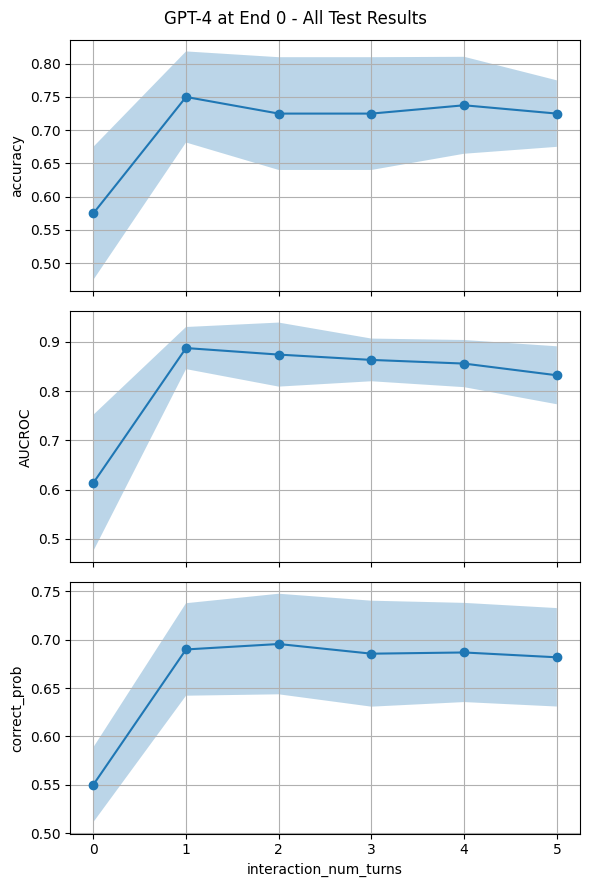

In [95]:
# Plot metrics for df1
fig1, axes1 = plot_metrics(df1, title='GPT-4 at End 0 - All Test Results')

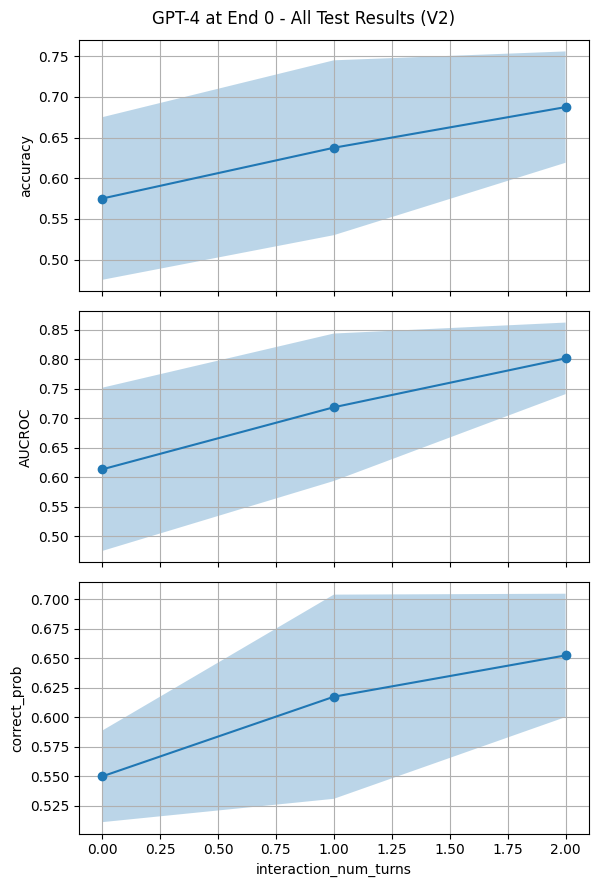

In [96]:
# Plot metrics for df2
fig2, axes2 = plot_metrics(df2, title='GPT-4 at End 0 - All Test Results (V2)')

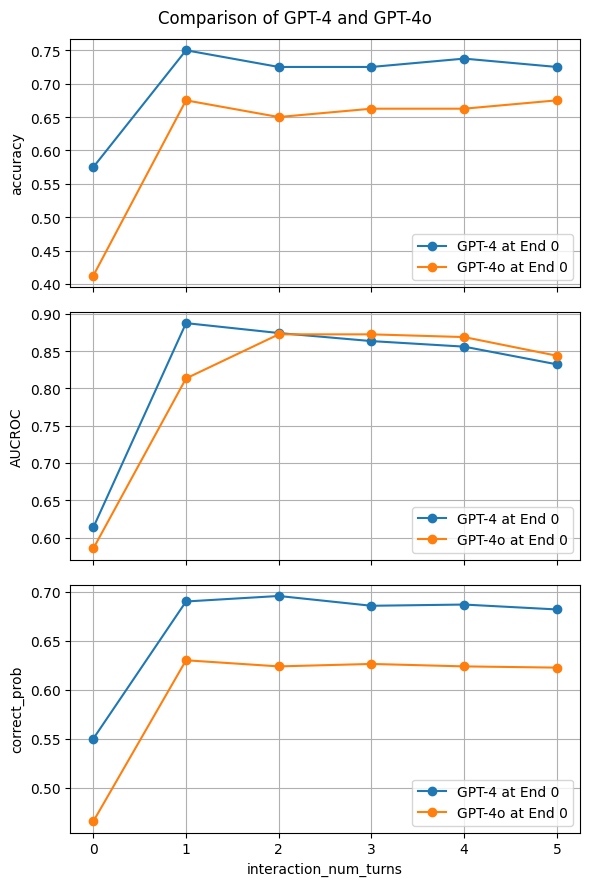

In [97]:
# Compare df1 and df3
fig3, axes3 = compare_dataframes([df1, df3], ['GPT-4 at End 0', 'GPT-4o at End 0'], title='Comparison of GPT-4 and GPT-4o')

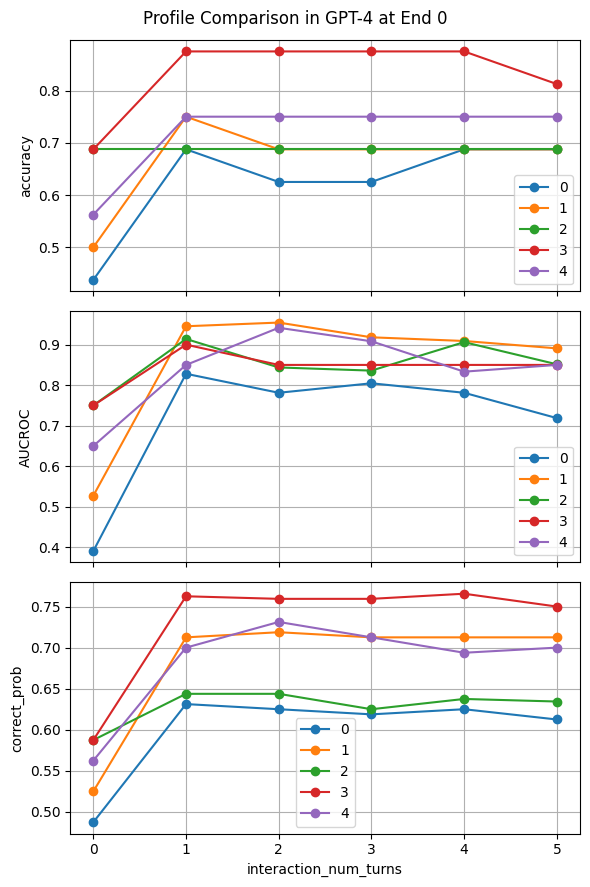

In [98]:
# Compare profiles in df1
fig4, axes4 = compare_profiles(df1, 'profile_id', title='Profile Comparison in GPT-4 at End 0')